# Generieke template inladen RGB_images

*This notebook is made to run inside Google colab or the [pxl_ML_Docker_v2.0_Tensorflow](https://github.com/PXLAIRobotics/PXL_ML_Docker_v2.0_TensorFlow) container.*

## Installations

### HuggingFace

In [363]:
!pip install datasets
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


#### Login to HuggingFace by token

In [364]:
from huggingface_hub import notebook_login
notebook_login()

### Kaggle

In [365]:
!pip install kaggle


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


#### Kaggle token
  
Please get your kaggle.json file from kaggle and place it in:
*For container:*  
'notebooks'-folder  
  
*For Google colab:*  
'contents'-folder  

In [366]:
!mkdir ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/user/.kaggle’: File exists


### Roboflow

In [367]:
!pip install roboflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


## Imports

In [368]:
import pandas as pd
import numpy as np
import io
import os
import json
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from datasets import load_dataset
from opendatasets import download as load_opendataset
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from roboflow import Roboflow

## General Class

In [369]:
class Generic_dataset_analysis:
  def __init__(self):  #constructor not used
    raise RuntimeError("Not required to create an instance of this class. This class only has static functions.")
  
  @staticmethod
  def _load_json(path):   #intenal function to load the json-file to convert the class numbers into class names
    while True:
        if os.path.isdir(path):
            items = os.listdir(path)
            items = [item for item in items if not item.endswith('.lock')]
            if len(items) == 1:
                subdirectory = items[0]
                path = os.path.join(path, subdirectory)
            else:
                break
        else:
            break
    path = glob.glob(os.path.join(path, "*.json"))
    with open(path[0], 'r') as file:
        json_data = json.load(file)
    names = json_data['features']['label']['names']
    return(names)
  
  @staticmethod
  def _add_single_folders_to_path(path):    #internal function. if a download contains nested single folders, they get added to the path before copy.
    directory = Path(path)
    folder_content = sorted(directory.iterdir())
    while (len(folder_content) == 1):
      path += '/' + folder_content[0].name
      directory = Path(path)
      folder_content = sorted(directory.iterdir())
    return path

  @staticmethod
  def load_classification_dataset_from_url(url, label_col_name=None):  #main function. load a dataset by passing the url. Huggingface needs a label columnname to work correctly.

    if not os.path.exists("dataset/"):
      os.makedirs("dataset/")
    elif len(os.listdir("dataset/")) > 0:
      raise RuntimeError("'dataset' folder not empty. Please delete all files first by running the 'remove_dataset()' function of this class.")
    
    split_url = url.split("/")

    if(split_url[2] == "huggingface.co"):
      datasets = load_dataset(split_url[-2] + "/" + split_url[-1])
      dataframes_map = {split: datasets[split].to_pandas() for split in datasets.keys()}

      hf_path = os.path.expanduser('~/.cache/huggingface/datasets/')
      new_path = hf_path + split_url[4] + '___' + split_url[5].lower() + "/"

      if(label_col_name == 'label'):
          folder_names = Generic_dataset_analysis._load_json(new_path)

      for key in list(dataframes_map.keys()):
        image_counter = 0
        friendly_key = key
        if(key[0:2] == "te"):
          friendly_key = "test"
        elif(key[0:2] == "tr"):
          friendly_key = "train"
        elif(key[0:2] == "va"):
          friendly_key = "validation"
        
        for index, row in dataframes_map.get(key).iterrows():
        
          classification_class = row[label_col_name]
          if(type(classification_class) == int):
            path = "./dataset/{}/{}".format(friendly_key, folder_names[classification_class])
          else:
            path = "./dataset/{}/{}".format(friendly_key, classification_class)

          binary_data = row['image'].get('bytes', None)
          if binary_data:
            stream = io.BytesIO(binary_data)
            image = Image.open(stream)
            if not os.path.exists(path):
              os.makedirs(path)
            image.save("{}/{}.png".format(path, image_counter))
          else:
            image_path = row['image'].get('path', None)
            if os.path.exists(image_path):
              image = Image.open(image_path)
              if not os.path.exists(path):
                os.makedirs(path)
              image.save("{}/{}.png".format(path, image_counter))
            else:
              print(f"Image path '{image_path}' does not exist.")

          image_counter += 1

    elif(split_url[2] == "www.kaggle.com"):
      link = " " + split_url[-2] + "/" + split_url[-1]
      unzip = split_url[-1]
                
      load_opendataset(url)
      download_path = Generic_dataset_analysis._add_single_folders_to_path(split_url[-1])
      stream = os.popen('cp -r ' + download_path + '/* dataset/')
      stream.close()
      
      directory = Path("dataset/")
      for item in directory.iterdir():
        if item.is_dir and item.name[0:2] == "te":
          os.replace("dataset/" + item.name, "dataset/test")
        elif item.is_dir and item.name[0:2] == "tr":
          os.replace("dataset/" + item.name, "dataset/train")
        elif item.is_dir and item.name[0:2] == "va":
          os.replace("dataset/" + item.name, "dataset/validation")

    elif(split_url[2] == "universe.roboflow.com"):
      rf = Roboflow(api_key="ztqwE4dHiRlu1JJrVnLE")
      project = rf.workspace(split_url[3]).project(split_url[4])
      all_versions = project.versions()

      latest_version = all_versions[0].version
      dataset = project.version(latest_version).download("tensorflow")

      dataset_folder_name = split_url[4] + '-' + latest_version
      stream = os.popen('cp -r ' + dataset_folder_name + '/* dataset/')
      stream.close()

      directory = Path("dataset/")
      for item in directory.iterdir():
        if item.is_dir and item.name[0:2] == "te":
          os.replace("dataset/" + item.name, "dataset/test")
        elif item.is_dir and item.name[0:2] == "tr":
          os.replace("dataset/" + item.name, "dataset/train")
        elif item.is_dir and item.name[0:2] == "va":
          os.replace("dataset/" + item.name, "dataset/validation")
    else:
      raise RuntimeError("This site is not supported...")

  @staticmethod
  def load_files_as_df():
    path = Path("dataset")
    dfs = []
    for split_dir in path.iterdir():
      image_paths = []
      labels = []
      for class_dir in split_dir.iterdir():
        if class_dir.is_dir():
          for img_path in class_dir.iterdir():
              if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                  image_paths.append(img_path)
                  labels.append(class_dir.name)
      dfs.append(pd.DataFrame({
        'image_path': image_paths,
        'label': labels
      }))
    return dfs

  @staticmethod
  def remove_dataset():   #function to remove the datasets folder.
    stream = os.popen('rm -rf ./dataset/')
    stream.close()

In [370]:
class Image_Display:
    def __init__(self):  #constructor not used
        raise RuntimeError("Not required to create an instance of this class. This class only has static functions.")

    @staticmethod 
    def find_images(folder_path):
        image_paths = []
        
        files_and_folders = os.listdir(folder_path)
        
        # Iterate through each item in the folder
        for item in files_and_folders:
            item_path = os.path.join(folder_path, item)
            
            # If item is a file, check if it's an image and add its path to image_paths
            if os.path.isfile(item_path):
                if item.endswith('.jpg') or item.endswith('.png') or item.endswith('.jpeg') or item.endswith('.bmp') or item.endswith('.gif'):
                    image_paths.append(item_path)
            # If item is a folder, recursively search for images within it
            elif os.path.isdir(item_path):
                image_paths.extend(Image_Display.find_images(item_path))
        
        return image_paths

    @staticmethod
    def display_random_images(num_images):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, 'dataset')
        folders = ['test', 'train', 'validate', 'val']
        
        image_paths = []
        
        # Iterate through each subfolder and check if it exists
        for folder in folders:
            folder_path = os.path.join(dataset_dir, folder)
            
            # Check if the subfolder exists
            if os.path.exists(folder_path):
                # Find images within the subfolder (including subfolders recursively)
                image_paths.extend(Image_Display.find_images(folder_path))
        
        print("Total images found:", len(image_paths))  # Debug output
        
        if not image_paths:
            print("No images found in the specified directories.")
            return
        
        random_images = random.sample(image_paths, min(num_images, len(image_paths)))
        
        # Display the selected random images
        fig = plt.figure(figsize=(15, 15))
        for i, image_path in enumerate(random_images):
            folder_name = image_path.split(os.sep)[-2]
            class_name = image_path.split(os.sep)[-3]
            
            ax = fig.add_subplot((num_images // 3) + 1, 3, i + 1)
            img = mpimg.imread(image_path)
            ax.imshow(img)
            ax.set_title(f'Folder: {class_name}, Class: {folder_name}')
            ax.axis('off')
        plt.show()


In [371]:
class Data_analysis():

    def __init__(self):
        raise RuntimeError("Not required to create an instance of this class. This class only has static functions.")
    
    
    @staticmethod
    def get_class_distribution_by_df():
        dfs = Generic_dataset_analysis.load_files_as_df()
        for df in dfs:
            #print(df.head())
            short_labels = []
            labels = df['label'].tolist()
            #print(labels)
            unique_values, counts = np.unique(labels, return_counts=True)
            short_unique_values = []
            for value in unique_values:
                short_unique_values.append(value[0:20])

            visual_df = pd.DataFrame({'Value': short_unique_values, 'Count': counts})
            plt.figure(figsize=(20, 6)) 
            plt.bar(visual_df['Value'], visual_df['Count'], color='skyblue')
            plt.xticks(rotation=45, ha='right')
            plt.xlabel('Class')
            plt.ylabel('Count')
            plt.title('test')
            plt.show()

    @staticmethod
    def class_distribution_bar(title):

        class_counts = Data_analysis._get_class_distribution()

        labels = list(class_counts.keys())
        counts = list(class_counts.values())
        percentages = [(count / sum(counts)) * 100 for count in counts] 

        labels, counts, percentages = zip(*sorted(zip(labels, counts, percentages), key=lambda x: x[1], reverse=True))
        
        plt.figure(figsize=(20, 6)) 
        bars = plt.bar(labels, counts, color='skyblue')
        
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        
        # Add percentages on top of the bars
        for bar, percent in zip(bars, percentages):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percent:.2f}%', ha='center', va='bottom')
        
        plt.show()

    @staticmethod
    def _get_class_distribution():
        dataset_dir = 'dataset/'
        class_counts = {}
        
        # Iterate through each subfolder and check if it exists
        for folder in ['train', 'test', 'validate']:
            folder_path = os.path.join(dataset_dir, folder)
            
            # Check if the subfolder exists
            if os.path.exists(folder_path):
                # Iterate through each subfolder (class folder)
                for class_folder in os.listdir(folder_path):
                    class_folder_path = os.path.join(folder_path, class_folder)
                    # Check if it's a directory
                    if os.path.isdir(class_folder_path):
                        # Count the number of images in the class folder
                        num_images = len([file for file in os.listdir(class_folder_path) if file.endswith('.jpg') or file.endswith('.png')])
                        # Add the count to class_counts dictionary
                        class_counts[class_folder] = class_counts.get(class_folder, 0) + num_images
        
        return class_counts
    
    @staticmethod
    def get_df_min_max_image_size():
        dfs = Generic_dataset_analysis.load_files_as_df()
        for df in dfs:
            df.iter

In [372]:


def get_class_distribution_by_df():
    dfs = Generic_dataset_analysis.load_files_as_df()
    for df in dfs:
        #print(df.head())
        short_labels = []
        labels = df['label'].tolist()
        #print(labels)
        unique_values, counts = np.unique(labels, return_counts=True)
        short_unique_values = []
        for value in unique_values:
            short_unique_values.append(value[0:20])

        visual_df = pd.DataFrame({'Value': short_unique_values, 'Count': counts})
        plt.figure(figsize=(20, 6)) 
        plt.bar(visual_df['Value'], visual_df['Count'], color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('test')
        plt.show()


Glyph 26408 (\N{CJK UNIFIED IDEOGRAPH-6728}) missing from current font.
Glyph 26825 (\N{CJK UNIFIED IDEOGRAPH-68C9}) missing from current font.
Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
Glyph 26577 (\N{CJK UNIFIED IDEOGRAPH-67D1}) missing from current font.
Glyph 27224 (\N{CJK UNIFIED IDEOGRAPH-6A58}) missing from current font.
Glyph 23660 (\N{CJK UNIFIED IDEOGRAPH-5C6C}) missing from current font.
Glyph 26893 (\N{CJK UNIFIED IDEOGRAPH-690D}) missing from current font.
Glyph 29289 (\N{CJK UNIFIED IDEOGRAPH-7269}) missing from current font.
Glyph 23565 (\N{CJK UNIFIED IDEOGRAPH-5C0D}) missing from current font.
Glyph 26973 (\N{CJK UNIFIED IDEOGRAPH-695D}) missing from current font.
Glyph 26705 (\N{CJK UNIFIED IDEOGRAPH-6851}) missing from current font.
Glyph 20061 (\N{CJK UNIFIED IDEOGRAPH-4E5D}) missing from current font.
Glyph 38622 (\N{CJK UNIFIED IDEOGRAPH-96DE}) missing from current font.
Glyph 34507 (\N{CJK UNIFIED IDEOGRAPH-86CB}) missing from curren

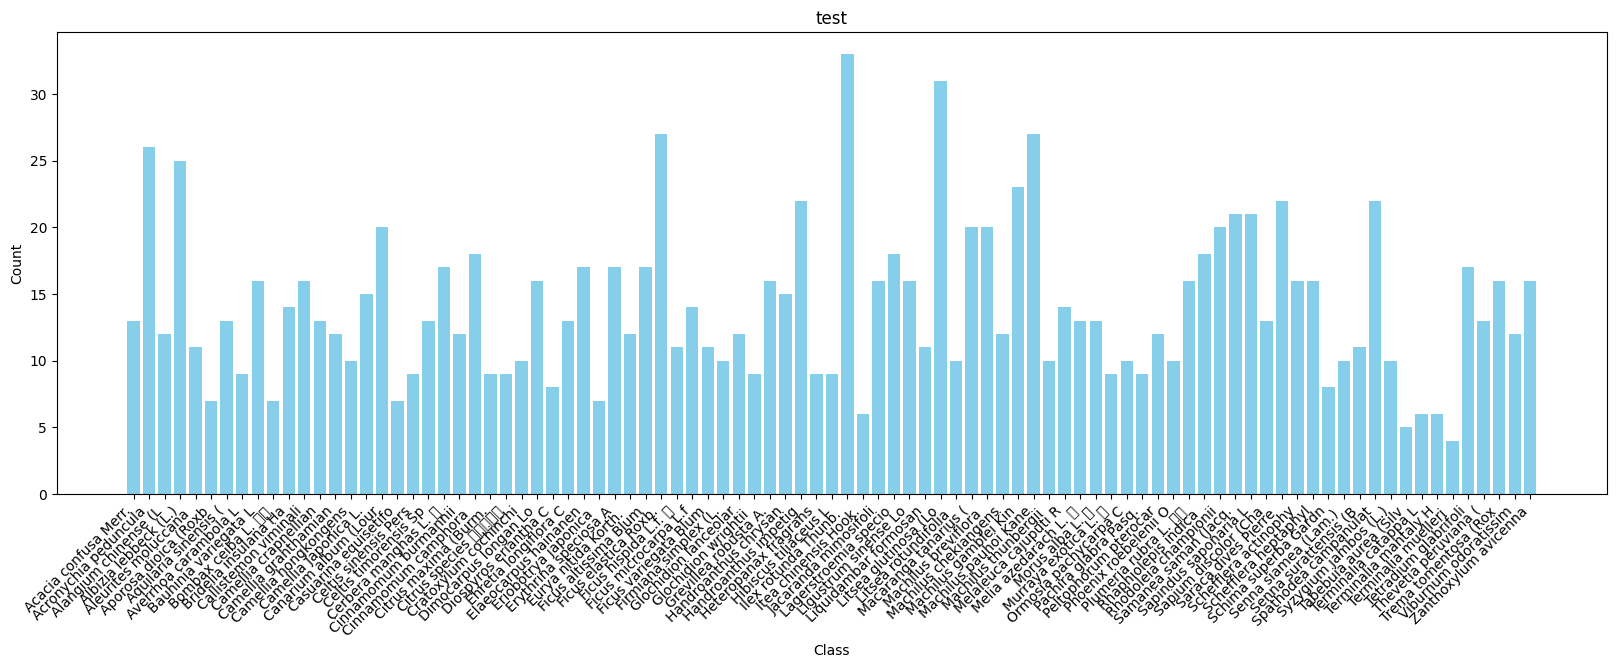

In [ ]:
Data_analysis.get_class_distribution_by_df()

## Algemene code

### Inladen verschillende data sources

#### Clear dataset folder 

In [ ]:
Generic_dataset_analysis.remove_dataset()

#### HuggingFace

##### Test 1

In [ ]:
Generic_dataset_analysis.load_classification_dataset_from_url('https://huggingface.co/datasets/OttoYu/Tree-Species', 'label')

Resolving data files:   0%|          | 0/1309 [00:00<?, ?it/s]

Total images found: 1309


Glyph 34880 (\N{CJK UNIFIED IDEOGRAPH-8840}) missing from current font.
Glyph 26704 (\N{CJK UNIFIED IDEOGRAPH-6850}) missing from current font.
Glyph 32005 (\N{CJK UNIFIED IDEOGRAPH-7D05}) missing from current font.
Glyph 33457 (\N{CJK UNIFIED IDEOGRAPH-82B1}) missing from current font.
Glyph 33655 (\N{CJK UNIFIED IDEOGRAPH-8377}) missing from current font.
Glyph 21514 (\N{CJK UNIFIED IDEOGRAPH-540A}) missing from current font.
Glyph 37912 (\N{CJK UNIFIED IDEOGRAPH-9418}) missing from current font.
Glyph 29579 (\N{CJK UNIFIED IDEOGRAPH-738B}) missing from current font.
Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from current font.
Glyph 33590 (\N{CJK UNIFIED IDEOGRAPH-8336}) missing from current font.


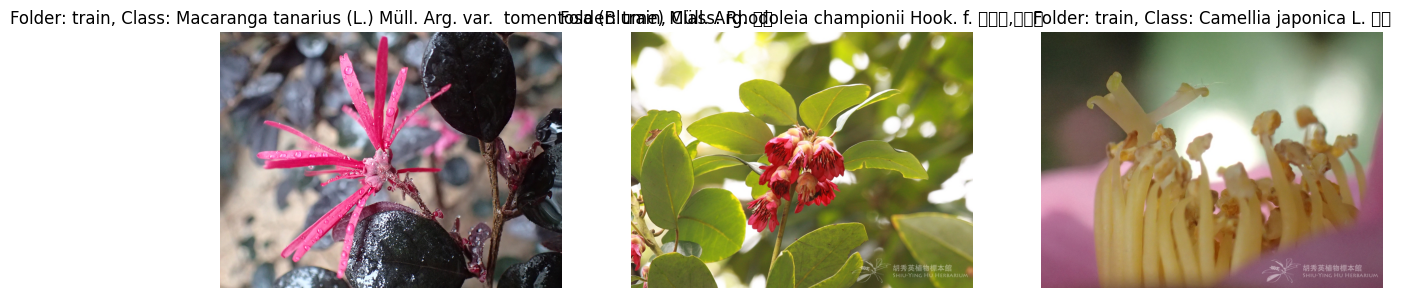

In [ ]:
Image_Display.display_random_images(3)

Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from current font.
Glyph 37941 (\N{CJK UNIFIED IDEOGRAPH-9435}) missing from current font.
Glyph 20908 (\N{CJK UNIFIED IDEOGRAPH-51AC}) missing from current font.
Glyph 38738 (\N{CJK UNIFIED IDEOGRAPH-9752}) missing from current font.
Glyph 28538 (\N{CJK UNIFIED IDEOGRAPH-6F7A}) missing from current font.
Glyph 27073 (\N{CJK UNIFIED IDEOGRAPH-69C1}) missing from current font.
Glyph 27193 (\N{CJK UNIFIED IDEOGRAPH-6A39}) missing from current font.
Glyph 21360 (\N{CJK UNIFIED IDEOGRAPH-5370}) missing from current font.
Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
Glyph 27029 (\N{CJK UNIFIED IDEOGRAPH-6995}) missing from current font.
Glyph 27233 (\N{CJK UNIFIED IDEOGRAPH-6A61}) missing from current font.
Glyph 21032 (\N{CJK UNIFIED IDEOGRAPH-5228}) missing from current font.
Glyph 33457 (\N{CJK UNIFIED IDEOGRAPH-82B1}) missing from curren

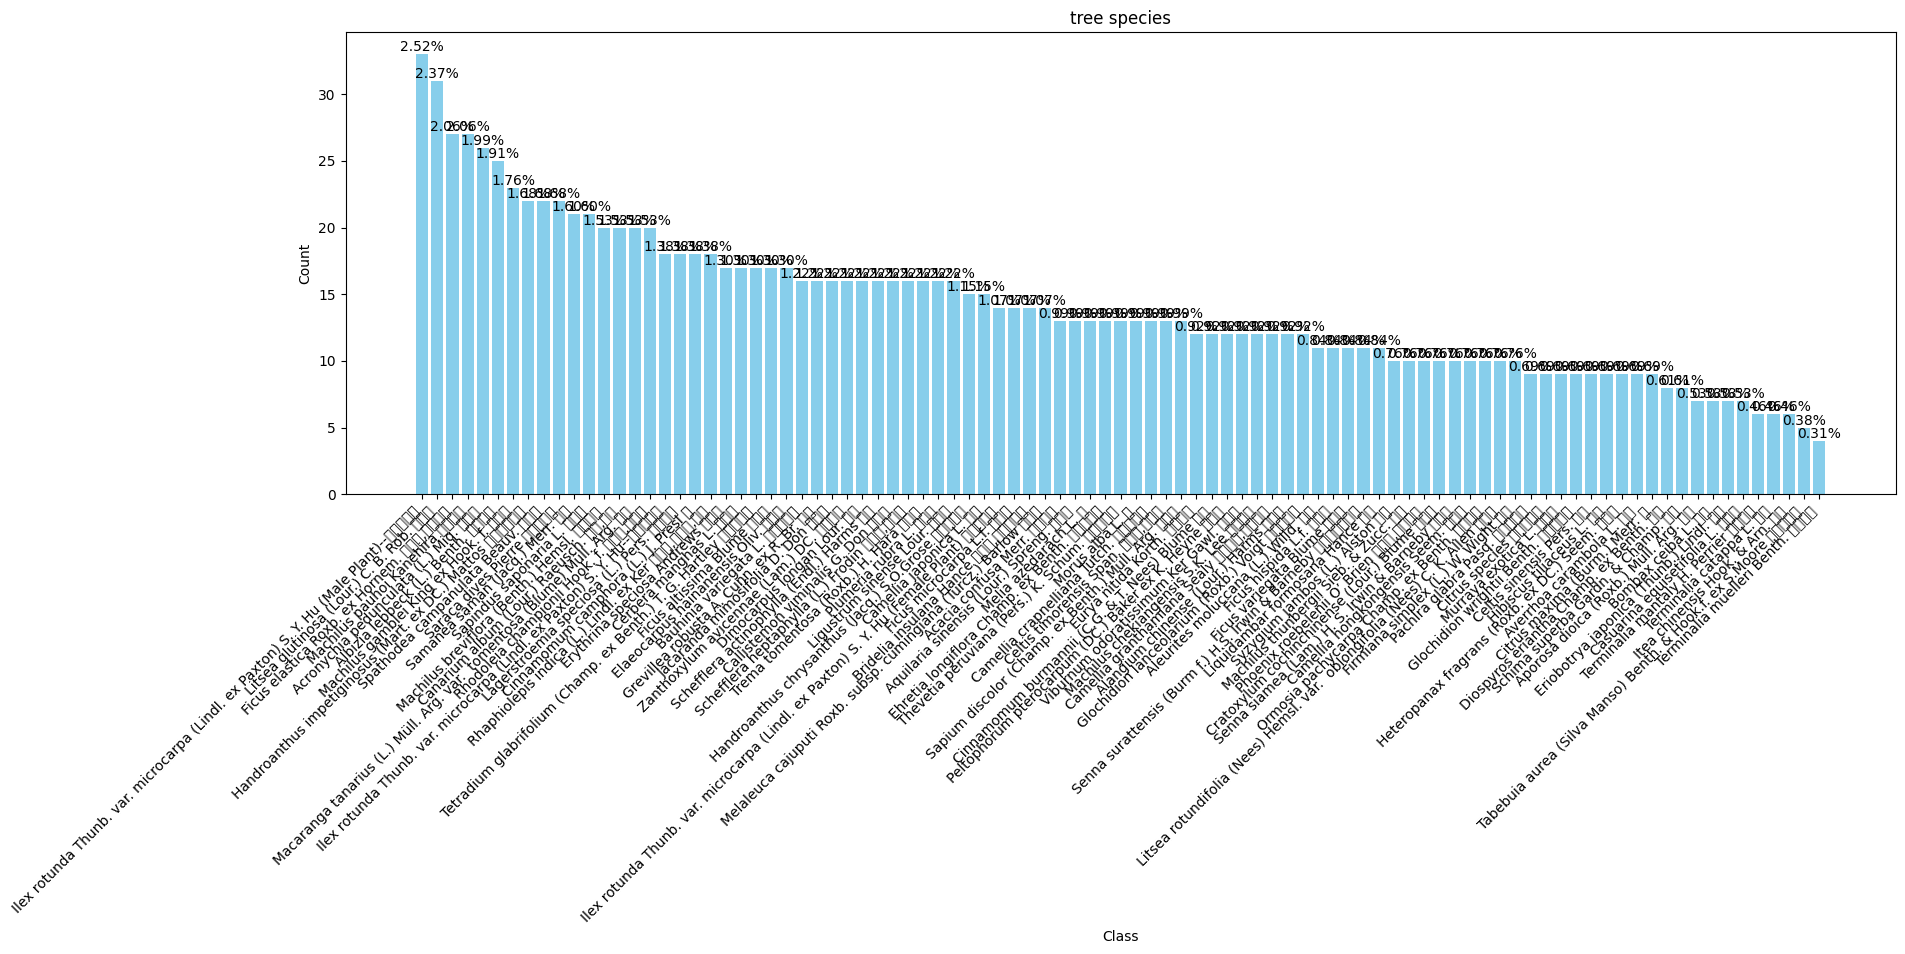

In [ ]:
Data_analysis.class_distribution_bar('tree species')

##### Test 2

In [ ]:
Generic_dataset_analysis.remove_dataset()

In [ ]:
Generic_dataset_analysis.load_classification_dataset_from_url('https://huggingface.co/datasets/mdfrearth/Plants', 'label')

Resolving data files:   0%|          | 0/78 [00:00<?, ?it/s]

Total images found: 78


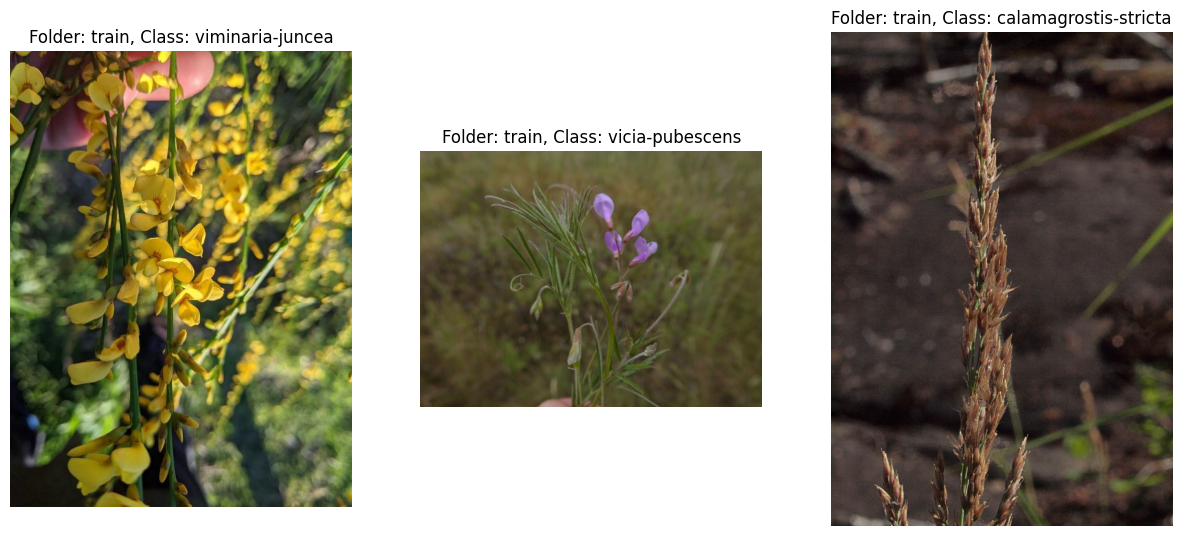

In [ ]:
Image_Display.display_random_images(3)

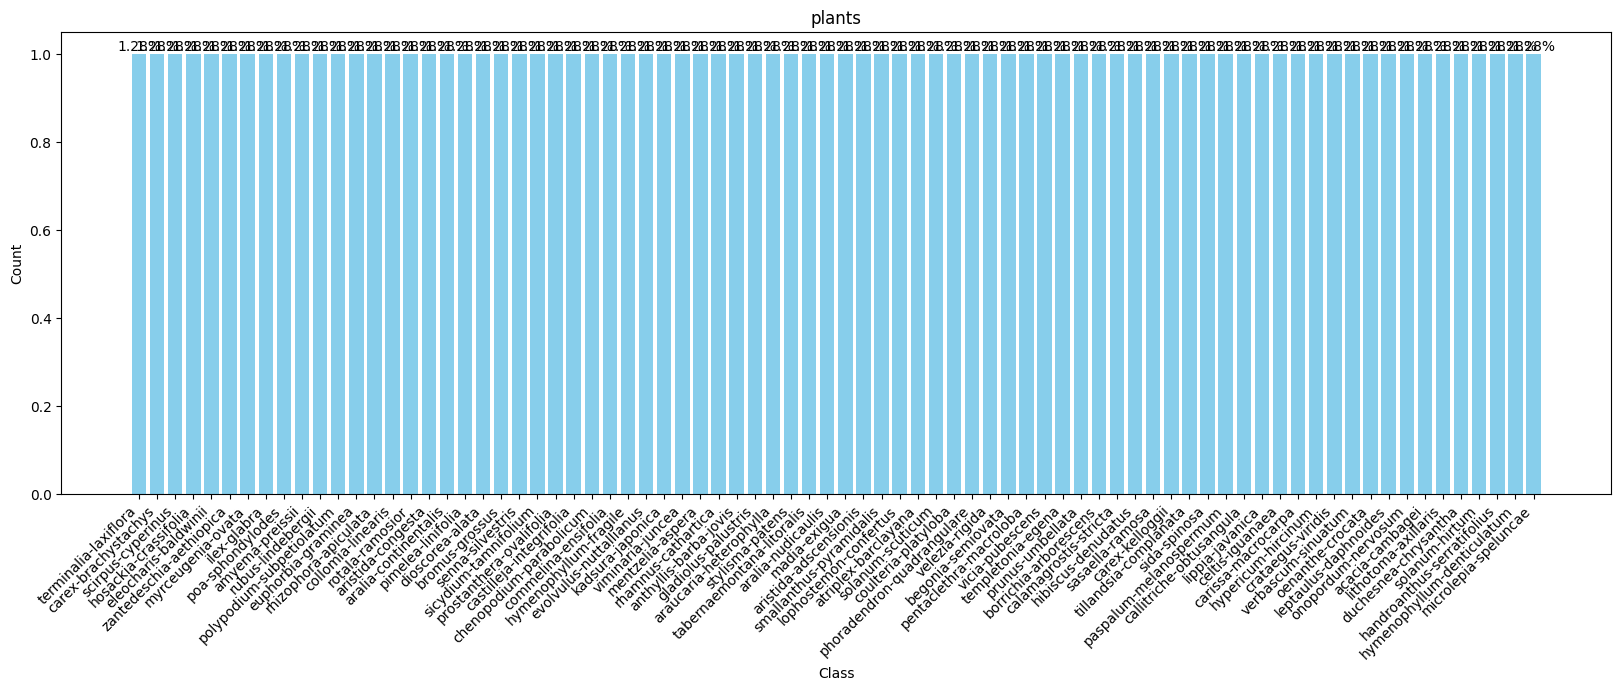

In [ ]:
Data_analysis.class_distribution_bar('plants')

##### Test 3

In [ ]:
Generic_dataset_analysis.remove_dataset()

In [ ]:
Generic_dataset_analysis.load_classification_dataset_from_url('https://huggingface.co/datasets/Fillster/plants', 'text')

Total images found: 40


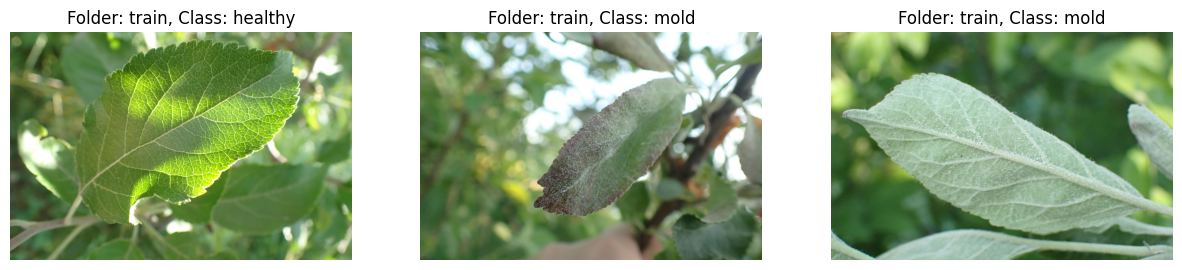

In [ ]:
Image_Display.display_random_images(3)

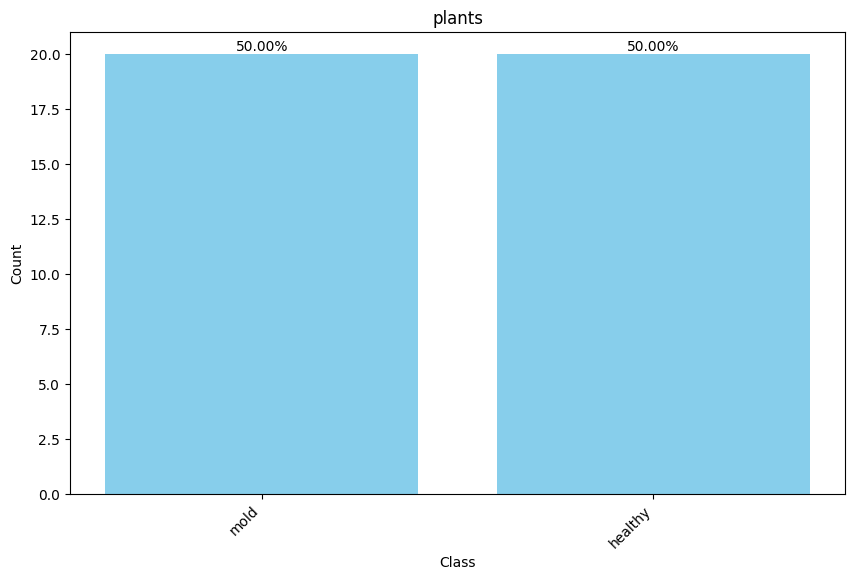

In [ ]:
class_distribution_bar('plants')

#### Kaggle

##### Test 1

In [ ]:
Generic_dataset_analysis.remove_dataset()

In [ ]:
Generic_dataset_analysis.load_classification_dataset_from_url('https://www.kaggle.com/datasets/erickendric/tree-dataset-of-urban-street-classification-tree')

Skipping, found downloaded files in "./tree-dataset-of-urban-street-classification-tree" (use force=True to force download)


Total images found: 2906


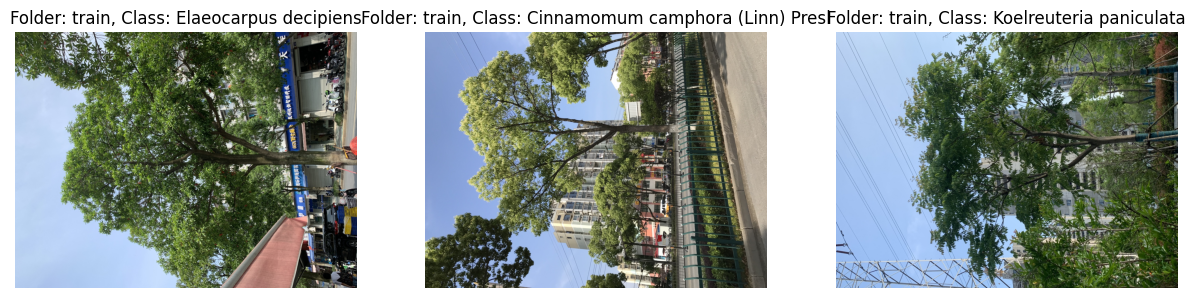

In [ ]:
Image_Display.display_random_images(3)

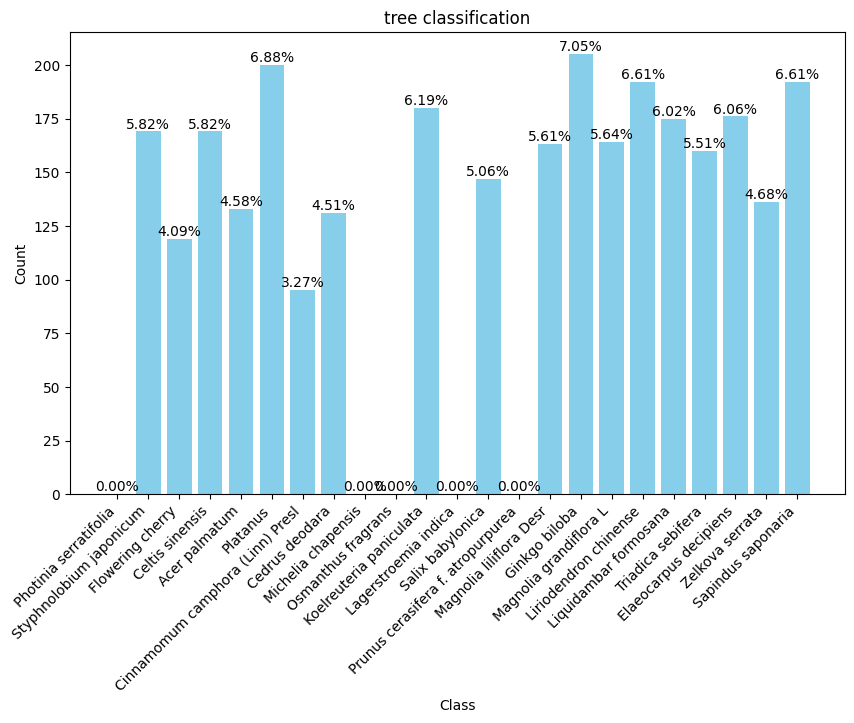

In [ ]:
class_distribution_bar('tree classification')

##### Test 2

#### RoboFlow

##### Test1

In [ ]:
Generic_dataset_analysis.remove_dataset()

In [ ]:
Generic_dataset_analysis.load_classification_dataset_from_url('https://universe.roboflow.com/cheng-kung-uni/tree_gazeb/model/')

loading Roboflow workspace...
loading Roboflow project...


Total images found: 113


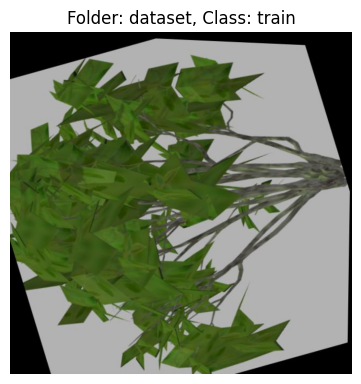

In [ ]:
Image_Display.display_random_images(1)

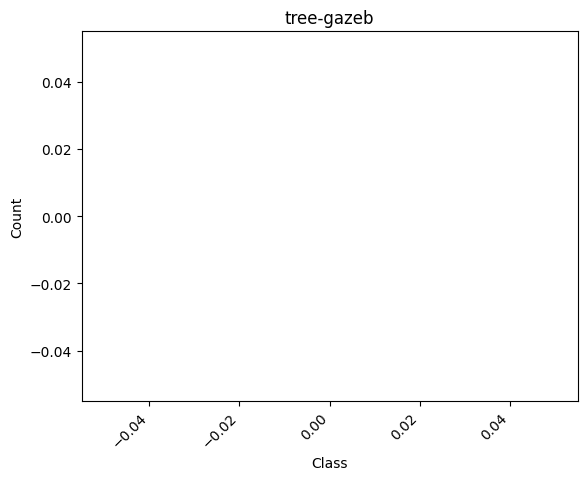

In [ ]:
class_distribution_bar('tree-gazeb')

### Data visualizatie